In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install gdown

In [6]:
import gdown
url = "https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0"
gdown.download(url, "data.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&export=download&authuser=0&confirm=t&uuid=deadd947-9089-4b08-99e4-83712149d3a2
To: /kaggle/working/data.zip
100%|██████████| 2.25G/2.25G [00:17<00:00, 129MB/s] 


'data.zip'

In [7]:
!unzip -q data.zip
print("data unzipped")

data unzipped


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Define dataset paths
IMAGE_DIR = "/kaggle/working/MSFD/1/face_crop"
MASK_DIR = "/kaggle/working//MSFD/1/face_crop_segmentation"
IMG_SIZE = (128, 128)
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 8
EPOCHS = 50

In [7]:
import os
import cv2
import numpy as np

def data_generator(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32):
    image_files = sorted(os.listdir(image_dir))  
    mask_files = sorted(os.listdir(mask_dir))

    while True:  # Infinite loop for generator
        for i in range(0, len(image_files), batch_size):
            batch_images, batch_masks = [], []

            for img_file, mask_file in zip(image_files[i:i+batch_size], mask_files[i:i+batch_size]):
                img = cv2.imread(os.path.join(image_dir, img_file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                img = cv2.resize(img, img_size) / 255.0  

                mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                mask = np.expand_dims(mask, axis=-1)  
                mask = mask / 255.0  

                batch_images.append(img)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

# Example usage
train_generator = data_generator(IMAGE_DIR, MASK_DIR, batch_size=32)
X_batch, Y_batch = next(train_generator)  # Get a single batch

print(f"Batch loaded: {X_batch.shape}, {Y_batch.shape}")

Batch loaded: (32, 128, 128, 3), (32, 128, 128, 1)


In [9]:
# Split dataset (80% Train, 20% Validation)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define U-Net Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def unet(input_shape=(128, 128, 3), dropout_rate=0.2):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(dropout_rate)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(dropout_rate)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(dropout_rate)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(dropout_rate)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Metrics
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

In [16]:
# Compile Model
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy", iou_metric, dice_metric])

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# Save Model
model.save("unet_mask_segmentation.h5")

Epoch 1/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 130s 106ms/step - accuracy: 0.5592 - dice_metric: 0.7688 - iou_metric: 0.6304 - loss: 0.3585 - val_accuracy: 0.5582 - val_dice_metric: 0.8159 - val_iou_metric: 0.6904 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 2/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.5816 - dice_metric: 0.8125 - iou_metric: 0.6854 - loss: 0.2805 - val_accuracy: 0.5777 - val_dice_metric: 0.8194 - val_iou_metric: 0.6953 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 3/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 77s 82ms/step - accuracy: 0.5826 - dice_metric: 0.8151 - iou_metric: 0.6891 - loss: 0.2759 - val_accuracy: 0.5805 - val_dice_metric: 0.8145 - val_iou_metric: 0.6884 - val_loss: 0.2780 - learning_rate: 0.0010
Epoch 4/50
939/939 ━━━━━━━━━━━━━━━━━━━━ 77s 82ms/step - accuracy: 0.5851 - dice_metric: 0.8154 - iou_metric: 0.6896 - loss: 0.2756 - val_accuracy: 0.5705 - val_dice_metric: 0.8231 - val_iou_metric: 0.7007 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 

In [44]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

class MSFDDataset(tf.keras.utils.Sequence):
    def __init__(self, image_files, segmentation_files, img_size=(128, 128), batch_size=32):
        self.image_files = image_files
        self.segmentation_files = segmentation_files
        self.img_size = img_size
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_files[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_segmentations = self.segmentation_files[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        images = []
        segmentations = []
        
        for img_path, seg_path in zip(batch_images, batch_segmentations):
            image = cv2.imread(img_path)
            if image is None:
                continue  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.img_size[1], self.img_size[0])).astype(np.float32) / 255.0
            
            segmentation = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
            if segmentation is None:
                continue  
            segmentation = cv2.resize(segmentation, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_NEAREST)
            segmentation = segmentation.astype(np.uint8)  
            
            images.append(image)
            segmentations.append(segmentation)
        
        images = np.array(images, dtype=np.float32)
        segmentations = np.array(segmentations, dtype=np.uint8)
        
        return images, segmentations

# Load dataset paths
dataset_path = "/kaggle/working/MSFD/1"
face_dir = os.path.join(dataset_path, "face_crop")
segmentation_dir = os.path.join(dataset_path, "face_crop_segmentation")

image_files = []
segmentation_files = []

for img_name in os.listdir(face_dir):
    img_path = os.path.join(face_dir, img_name)
    seg_path = os.path.join(segmentation_dir, img_name)
    
    if os.path.exists(img_path) and os.path.exists(seg_path):
        image_files.append(img_path)
        segmentation_files.append(seg_path)

# Train-test split (80-20)
train_images, val_images, train_masks, val_masks = train_test_split(image_files, segmentation_files, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = MSFDDataset(train_images, train_masks)
val_dataset = MSFDDataset(val_images, val_masks)

print(f"Training samples: {len(train_images)}, Validation samples: {len(val_images)}")


Training samples: 7505, Validation samples: 1877


In [45]:
import keras_tuner as kt
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Convert dataset to NumPy arrays
def get_data_from_generator(generator):
    X, Y = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        X.append(x_batch)
        Y.append(y_batch)
    return np.concatenate(X), np.concatenate(Y)

# Load datasets
X_train, Y_train = get_data_from_generator(train_dataset)
X_val, Y_val = get_data_from_generator(val_dataset)

# Ensure masks are in the correct format
Y_train = Y_train[..., np.newaxis] / 255.0  # Normalize mask
Y_val = Y_val[..., np.newaxis] / 255.0

# IoU and Dice Metrics
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Hypermodel for Keras Tuner
def build_unet(hp):
    input_shape = (128, 128, 3)
    dropout_rate = hp.Float("dropout_rate", 0.1, 0.4, step=0.1)
    use_batchnorm = hp.Boolean("use_batchnorm")
    base_filters = hp.Choice("filters_base", [16,32,64])
    depth = hp.Int("depth", 3, 5)

    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    skips = []

    # Encoder
    for i in range(depth):
        filters = base_filters * (2**i)
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        skips.append(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Bottleneck
    filters = base_filters * (2**depth)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    if use_batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    if use_batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)

    # Decoder
    for i in reversed(range(depth)):
        filters = base_filters * (2**i)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, skips[i]])
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", iou_metric, dice_metric]
    )

    return model

# Tuner
tuner = kt.RandomSearch(
    build_unet,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="unet_tuning",
    project_name="image_segmentation"
)

# Search for best hyperparameters
tuner.search(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=16
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train best model
history = best_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    ]
)

# Save best model
best_model.save("unet_best_tuned.h5")


Trial 10 Complete [00h 03m 15s]
val_loss: 0.09013040363788605

Best val_loss So Far: 0.07129344344139099
Total elapsed time: 00h 50m 56s
Epoch 1/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 102s 191ms/step - accuracy: 0.5996 - dice_metric: 0.6314 - iou_metric: 0.5305 - loss: 0.3535 - val_accuracy: 0.6172 - val_dice_metric: 0.8968 - val_iou_metric: 0.8135 - val_loss: 0.1657 - learning_rate: 1.6228e-04
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.6209 - dice_metric: 0.9062 - iou_metric: 0.8293 - loss: 0.1535 - val_accuracy: 0.6255 - val_dice_metric: 0.9289 - val_iou_metric: 0.8678 - val_loss: 0.1190 - learning_rate: 1.6228e-04
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.6259 - dice_metric: 0.9328 - iou_metric: 0.8745 - loss: 0.1143 - val_accuracy: 0.6275 - val_dice_metric: 0.9453 - val_iou_metric: 0.8966 - val_loss: 0.0940 - learning_rate: 1.6228e-04
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.6285 - dice_metric: 0.9433 - iou_m

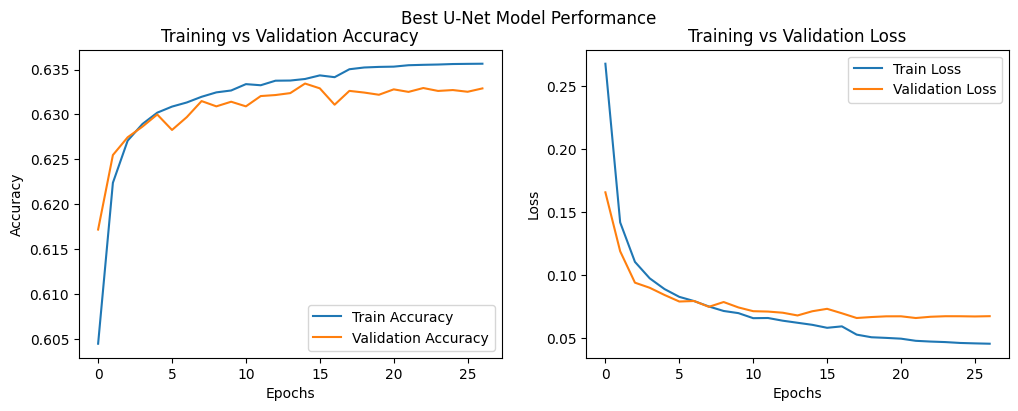

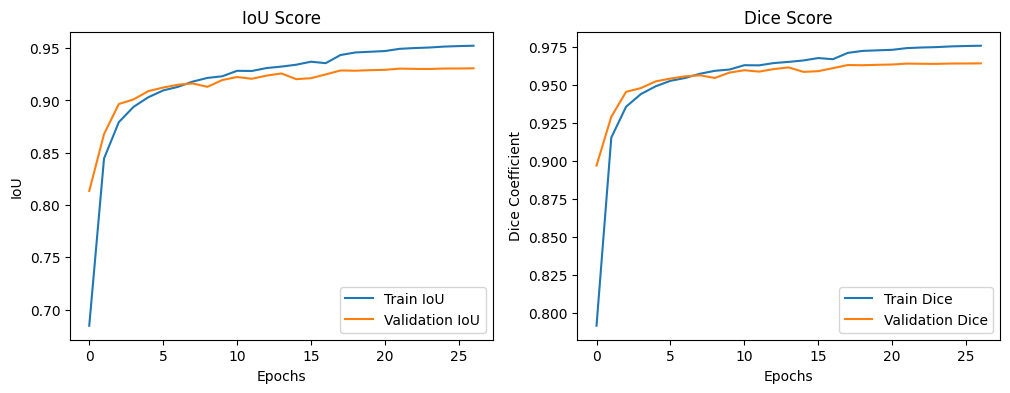

In [46]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_model_performance(history, title="Model Performance"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    axes[0].plot(history.history["accuracy"], label="Train Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_title("Training vs Validation Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history["loss"], label="Train Loss")
    axes[1].plot(history.history["val_loss"], label="Validation Loss")
    axes[1].set_title("Training vs Validation Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.suptitle(title)
    plt.show()

# Function to plot IoU and Dice Score
def plot_iou_dice(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # IoU Metric
    axes[0].plot(history.history["iou_metric"], label="Train IoU")
    axes[0].plot(history.history["val_iou_metric"], label="Validation IoU")
    axes[0].set_title("IoU Score")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("IoU")
    axes[0].legend()

    # Dice Score
    axes[1].plot(history.history["dice_metric"], label="Train Dice")
    axes[1].plot(history.history["val_dice_metric"], label="Validation Dice")
    axes[1].set_title("Dice Score")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Dice Coefficient")
    axes[1].legend()

    plt.show()

# Plot for best tuned model
plot_model_performance(history, title="Best U-Net Model Performance")
plot_iou_dice(history)


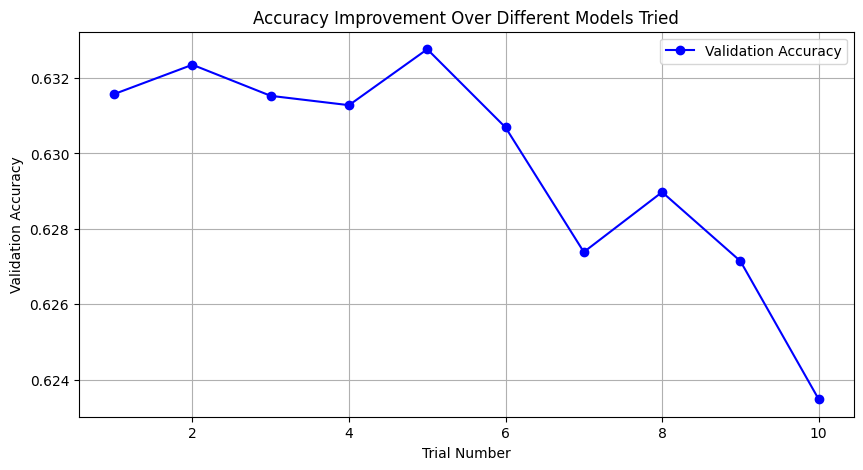

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Get all trials from the Keras Tuner
trials = tuner.oracle.get_best_trials(num_trials=10)  # Top 10 best trials

# Prepare data
data = []
for i, trial in enumerate(trials):
    hp_values = trial.hyperparameters.values
    val_acc = trial.metrics.get_best_value("val_accuracy")  # Get best validation accuracy
    data.append({"Trial": i + 1, "Validation Accuracy": val_acc})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot Accuracy Improvement Over Trials
plt.figure(figsize=(10, 5))
plt.plot(df["Trial"], df["Validation Accuracy"], marker="o", linestyle="-", color="b", label="Validation Accuracy")

plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Improvement Over Different Models Tried")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# Collect hyperparameter results
trial_results = []
for trial in tuner.oracle.trials.values():
    trial_results.append({
        "Trial": trial.trial_id,
        "learning_rate": trial.hyperparameters.get("learning_rate"),
        "filters_base": trial.hyperparameters.get("filters_base"),
        "dropout_rate": trial.hyperparameters.get("dropout_rate"),
        "depth": trial.hyperparameters.get("depth"),
        "Validation Accuracy": trial.metrics.get_best_value("val_accuracy"),
    })

# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(trial_results)

# Check if the data is properly stored
print(df.head())


  Trial  learning_rate  filters_base  dropout_rate  depth  Validation Accuracy
0    00       0.000268            32           0.1      3             0.627386
1    01       0.004123            32           0.3      4             0.632765
2    02       0.002243            32           0.2      4             0.632353
3    03       0.001325            16           0.3      4             0.631281
4    04       0.000162            64           0.4      5             0.631576


In [70]:
import plotly.express as px

fig = px.parallel_coordinates(
    df, 
    dimensions=["learning_rate", "filters_base", "dropout_rate", "depth", "Validation Accuracy"],
    color="Validation Accuracy",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(title="Hyperparameter Impact on Accuracy")
fig.show()


In [72]:
import plotly.express as px
import plotly.graph_objects as go

# Define a custom color scale
custom_color_scale = px.colors.sequential.Magma

# Create the parallel coordinates plot
fig = px.parallel_coordinates(
    df, 
    dimensions=["learning_rate", "filters_base", "dropout_rate", "depth", "Validation Accuracy"],
    color="Validation Accuracy",
    color_continuous_scale=custom_color_scale,
    title="Hyperparameter Impact on Accuracy"
)

# Update layout for a sleek look
fig.update_layout(
    template="plotly_dark",  # Dark theme for modern aesthetics
    title_font=dict(size=22, color="white", family="Arial"),
    coloraxis_colorbar=dict(title="Validation Accuracy"),
    font=dict(family="Arial", size=14, color="white"),
    margin=dict(l=50, r=50, t=50, b=50),
)

# Adjust line opacity through the `color` parameter
fig.update_traces(
    line=dict(color=df["Validation Accuracy"], colorscale=custom_color_scale, showscale=True)
)

# Show the plot
fig.show()


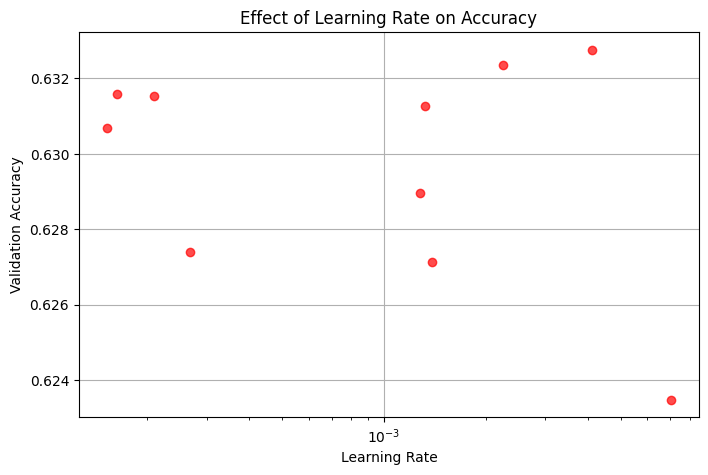

In [61]:
plt.figure(figsize=(8, 5))
plt.scatter(df["learning_rate"], df["Validation Accuracy"], color="r", alpha=0.7)
plt.xscale("log")  # Since learning rate varies exponentially
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Learning Rate on Accuracy")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


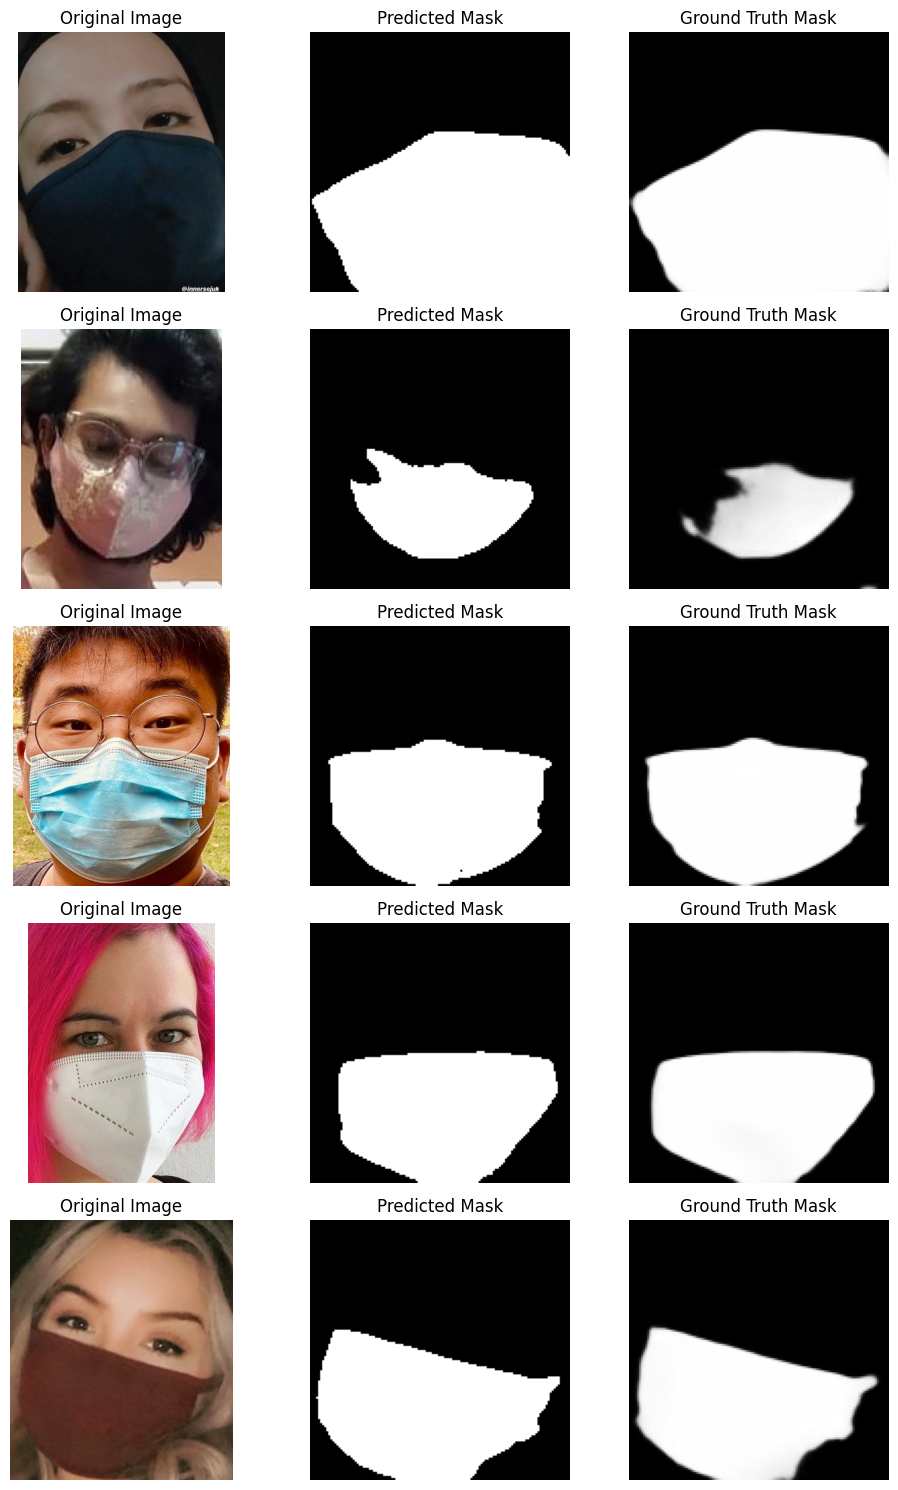

In [66]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import cv2

# Load the trained U-Net model
model = tf.keras.models.load_model("unet_best_tuned.h5")  # Update with the actual model path

# Select a few random test images
num_samples = 5  # Change as needed
sampled_indices = random.sample(range(len(val_images)), num_samples)

# Function to preprocess an image
def preprocess_image(img_path, img_size=(128, 128)):  # Update based on model input size
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size).astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Plot results
fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i, idx in enumerate(sampled_indices):
    img_path = val_images[idx]
    mask_path = val_masks[idx]

    # Load and preprocess image
    img = preprocess_image(img_path)

    # Predict mask
    mask_pred = model.predict(img)[0]  # Get first mask from batch
    mask_pred = (mask_pred > 0.5).astype(np.uint8)  # Apply thresholding

    # Load original image and mask for display
    orig_img = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    orig_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    orig_mask = cv2.resize(orig_mask, (128, 128))  # Resize for display

    # Display images
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title("Original Image")
    axes[i, 1].imshow(mask_pred.squeeze(), cmap="gray")
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 2].imshow(orig_mask, cmap="gray")
    axes[i, 2].set_title("Ground Truth Mask")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()
